In [3]:
# import normal libraries
import numpy as np
import illustris_python as il
import h5py

import sys
import os,sys,inspect
import os.path


In [19]:
import TNGtags.MakeTags.findAccTags as TAG

In [4]:
# import matplotlib libraries for plotting.
import matplotlib.pyplot as plt
%matplotlib inline


from matplotlib import rcParams
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['font.family'] = 'serif'
rcParams['figure.facecolor'] = 'w'

In [5]:
basePath = '/home/tnguser/sims.TNG/TNG100-1/output'
dataPath = '../Particles-TNG-100/'
snapNum0 = 99         
h0= 0.6774

## Find a List of MW-mass haloes at redshift z=0

In [6]:
GroupFirstSub = il.groupcat.loadHalos(basePath,snapNum0,fields=['GroupFirstSub'])

fields = ['SubhaloMassType',]
subhalos = il.groupcat.loadSubhalos(basePath,snapNum0,fields=fields)
dm=subhalos[:,1]*(1e10/h0)
sm=subhalos[:,4]*(1e10/h0)
mask=((dm>0.8e12) & (dm<2e12)) & ((sm>2e10) & (sm<1e11))
arg_list_prospective=np.where(mask)[0]

arg=np.in1d(arg_list_prospective,GroupFirstSub)
subfindID_prospective=arg_list_prospective[arg]

In [8]:
# choose one particular galaxy
subfindID0=subfindID_prospective[1]

## Read data of a particular subhalo 

They contain the information in several groups.
* PartType0 — GAS
* PartType1 — DM
* PartType2 — (unused)
* PartType3 — TRACERS
* PartType4 — STARS & WIND PARTICLES 
* PartType5 — BLACK HOLES.

In [10]:
gas=il.snapshot.loadSubhalo(basePath, snapNum0, subfindID0, 0)
dm= il.snapshot.loadSubhalo(basePath, snapNum0, subfindID0, 1)
stars=il.snapshot.loadSubhalo(basePath, snapNum0, subfindID0, 4)
BHs=il.snapshot.loadSubhalo(basePath, snapNum0, subfindID0, 5)

# To load data from a group, using the function 
def loadHalo(basePath, snapNum, id, partType, fields=None):
    """ Load all particles/cells of one type for a specific halo
        (optionally restricted to a subset fields). """
    # load halo length, compute offset, call loadSubset

## Stellar particles

In [13]:
# Information stored for stars
list(stars.keys())

['count',
 'BirthPos',
 'BirthVel',
 'Coordinates',
 'GFM_InitialMass',
 'GFM_Metallicity',
 'GFM_Metals',
 'GFM_MetalsTagged',
 'GFM_StellarFormationTime',
 'GFM_StellarPhotometrics',
 'Masses',
 'ParticleIDs',
 'Potential',
 'StellarHsml',
 'SubfindDMDensity',
 'SubfindDensity',
 'SubfindHsml',
 'SubfindVelDisp',
 'Velocities']

In [31]:
stellar_ids= stars['ParticleIDs']                  # unique id of the particle in the simulation  
stellar_coordinates= stars['Coordinates']/h0        # in Units of kpc/h
stellar_masses=stars['Masses']*1e10/h0              # in Units of 10^10 M_sun/h (by multiplying by 1e10 in solar units)
stellar_velocities=stars['Velocities']             # in Units of kms/s
stellar_formationtime=stars['GFM_StellarFormationTime'] # formation time of stars in terms of scale factor (see above).
stellar_metallicity=stars['GFM_Metallicity']       # Ratio of mass in metals to the total stellar mass (see below)

In [21]:
# Metallicity
# metal_mask = np.log10(stellar_metallicity) < -7
# stellar_metallicity[metal_mask] = 1e-7
    
# lmetallicity=np.log10(stellar_metallicity/0.0127) - factor
# If you wish to quote the metallicity as [M/H], factor = 0.
# If you wish to quote the metalliicty as [Fe/H], factor = 0.3 (consult with Eric later)    

### Get accreted Tags

In [20]:
(mask_mpb, mask_fof, mask_ext)=TAG.create_tags(stellar_ids, subfindID0, snapNum0, basePath, dataPath)
# Three masks where the particular star was born.
# mpb - main progenitor branch.
# fof - within the Group of the main progenitor branch.
# ext - was born external to the galaxy outside the group.

# would consider mask_mpb as 'real insitu stars'
# would consider mask_fof as 'commuter stars'
# would consider mask_ext as 'truly accreted stars'.

In [35]:
# The galaxy position is that in the main simulation. For the purpose of this, we will like to center it on the galaxy.
galpos1=np.median(dm['Coordinates']/h0,axis=0)
velpos1=np.median(dm['Velocities'],axis=0)

In [36]:
# get to the CM
stellar_coordinates=stellar_coordinates-galpos1
stellar_velocities=stellar_velocities-velpos1


In [37]:
# find the accreted component    
stellar_masses_acc              = stellar_masses[mask_ext]
stellar_coordinates_acc         = stellar_coordinates[mask_ext]
stellar_velocities_acc          = stellar_velocities[mask_ext]
stellar_formationtime_acc       = stellar_formationtime[mask_ext]
stellar_metallicity_acc         = stellar_metallicity[mask_ext]


In [38]:
total_stellar_mass=np.sum(stellar_masses)
total_accreted_stellar_mass=np.sum(stellar_masses_acc)

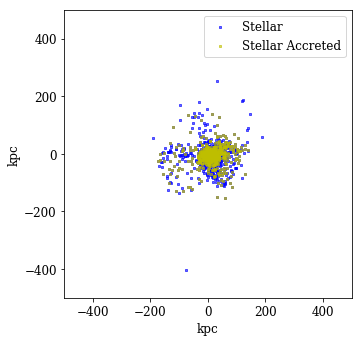

In [39]:
# example plot

# lets plot all the Dark matter and stellar particles, and show which stellar particles are accerted.
fig = plt.figure(figsize=(5, 5))
ax1=fig.add_axes([0.15,0.15,0.8,0.8])
ax1.set_xlim([-500,500])
ax1.set_ylim([-500,500])
ax1.set_xlabel("kpc")
ax1.set_ylabel("kpc")

ax1.scatter(stellar_coordinates[:,2],stellar_coordinates[:,0],c='b',alpha=0.6,marker=',',s=3,label="Stellar Insitu")
ax1.scatter(stellar_coordinates_acc[:,2],stellar_coordinates_acc[:,0],c='y',alpha=0.6,marker=',',s=3,label="Stellar Accreted")
plt.legend()
plt.show()